In [1]:
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed, asarray, load
from mtcnn.mtcnn import MTCNN
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder, Normalizer
from numpy import linalg as la
from matplotlib import pyplot
import os
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Face embedding obtention (for one face)
def get_embedding(model, face_pixels):
    face_pixels = face_pixels.astype("float32")
    mean, std = face_pixels.mean(), face_pixels.std()
    face_pixels = (face_pixels - mean)/std
    samples = np.expand_dims(face_pixels, axis = 0)
    yhat = model.predict(samples)
    return yhat[0]


# ROC curves data obtention
def metric_obtention(trainX2):
    how_many = len(trainX2) # how_many = 93

    # Formation of pairs (everyone with everyone)

    pairs = list() 
    # pairs = [ [img_i, img_j, label_i, label_j]   ] - img_i is the embedding of i

    for i in range(how_many):
        for j in range(i+1, how_many):
            pair = list()
            #print("(" + str(i) + "," + str(j) + ")")
            img_i = trainX2[i][0:-1]
            label_i = trainX2[i][-1]
            img_j = trainX2[j][0:-1]
            label_j = trainX2[j][-1]
            pair.append(img_i)
            pair.append(img_j)
            pair.append(label_i)
            pair.append(label_j)
            pairs.append(pair)

    #print(img_i.shape)
    #print(img_j.shape)
    #print(label_i)
    #print(label_j)
    #print(len(pairs)) - len(pairs) = 4278

    # 2) Pair comparison

    #threshold = [0.2, 0.5, 0.9]
    threshold = np.linspace(0.1, 0.9, num=9, endpoint=True, retstep=False, dtype=float, axis=0)
    Psame = list()
    Pdiff = list()
    for t in range(len(threshold)):
        #print("Threshold: " + str(threshold[t]))
        for pair in pairs:
            norm = np.linalg.norm(pair[0] - pair[1])**2
            comparison = [pair[0], pair[1], pair[2], pair[3], norm]
            if norm < threshold[t]:
                Psame.append(comparison)
            else:
                Pdiff.append(comparison)
        #print(pair[0])

    # comparison = [img_i, img_j, label_i, label_j, norm]

    #print(pair[0])
    #print(pair[1])
    #print(pair[2])
    #print(pair[3])
    print("Pairs: " + str(len(pairs)))
    print("Psame: " + str(len(Psame)))
    print("Pdiff: " + str(len(Pdiff)))
    #print(Psame[0])
    #plt.imshow(raw_trainX[int(pair[2])])
    #plt.show()
    #plt.imshow(raw_trainX[int(pair[3])])
    #plt.show()

    # 3) VAL and FAR rates

    VAL_list = []
    FAR_list = []
    TA_total = []
    FA_total = []
    for t in range(len(threshold)):
        TA = [] 
        FA = []
        ta_counter = 0
        fa_counter = 0
        for pair in Psame:
            if pair[-1] <= threshold[t]:
                TA.append(pair)
                ta_counter = len(TA)
                #print("TA para threshold:" + str(threshold[t]) + "es" + str(ta_counter))
                TA_total.append(TA)
        for pair in Pdiff:
            if pair[-1] <= threshold[t]:
                FA.append(pair)
                fa_counter = len(FA)
                #print("FA para threshold:" + str(threshold[t]) + "es" + str(fa_counter))
                TA_total.append(TA)
        val = ta_counter/len(Psame)
        print("VAL para threshold: " + str(threshold[t]) + " es: " + str(val))
        VAL_list.append(val)
        #print(VAL)
        far = fa_counter/len(Pdiff)
        print("FAR para threshold: " + str(threshold[t]) + " es: " + str(far))
        FAR_list.append(far)
        #FAR[t] += np.asarray(FAR_list)
    #VAL = np.asarray(VAL_list)
    #reverse_list_val = np.sorted()
    #FAR = np.asarray(FAR_list)   
    #for t in range(len(threshold)):
        #VAL = []
        #TA_count = TA.
        #v = len(TA)/len(Psame)
        #FAR = len(FA)/len(Pdiff)
        #print("TA: " + str(len(TA)))
        #print("FA: " + str(len(FA)))
        #print("VAL: " + str(VAL))
        #print("FAR: " + str(FAR))
    #ta_array = np.array(TA)
    #print(np.abs(ta_array)) 
    #print(len(ta_array))

    #ta = np.array(TA)
    #ps = np.array(Psame)
    #fa = np.array(FA)
    #pd = np.array(Pdiff)
    #val = abs(ta)/abs(ps)
    #far = abs(fa)/abs(pd)
    #print(VAL[0])
    #print(VAL[1])
    #print(VAL[2])
    ###print(FAR)
    
    #metrics = [pairs, Psame, Pdiff, threshold_value, TA, FA, VAL, FAR]
    #metrics = [pairs, Psame, Pdiff, TA, FA, VAL_list, FAR_list]
    metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]
    return metrics

# Plot a pair of faces
def face_pairs_plot(metrics_data, raw_imgs, how_many):
    for i in range(how_many):
        plt.figure()
        f, axarr = plt.subplots(1,2)
        axarr[0].imshow(raw_imgs[int(metrics_data[1][i][2])])
        axarr[1].imshow(raw_imgs[int(metrics_data[1][i][3])]) 
        # [1][i][2] means:
        # 1: Access Psame
        # i: Access the i-th term of Psame pairs
        # 2: Access the 2nd term of a single pair of Psame (which is the label of the img in the raw_imgs dataset)
    return

def ROC_plot(VAL, FAR):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    #ax.xaxis.set_ticks_position('top')
    ax.yaxis.grid(linestyle = '-', color = 'gray')
    plt.xticks(fontsize=14,fontweight='normal')
    plt.yticks(fontsize=14,fontweight='normal')
    plt.xlabel('FAR', fontsize=14)
    plt.ylabel('VAL', fontsize=14)
    plt.xlim(0,0.015)
    plt.ylim(0,1)
    #ax.invert_xaxis()
    #ax.plot(FAR_list, VAL_list, 'g-', linewidth = 1.5)
    ax.plot(FAR, VAL, 'g-', linewidth = 1.5)
    plt.show()
    return

# 5-celebs - MaxPool Retrained

In [54]:
data = np.load("../data/datasets/5-celebrity-faces-dataset.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [55]:
data = np.load("../data/datasets/5-celebrity-faces-dataset.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "../models/facenet_keras_maxpool_retrain.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('../data/datasets/5-celebrity-faces-dataset-embeddings.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
(93, 128)
(25, 128)


In [56]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("../data/datasets/5-celebrity-faces-dataset-embeddings.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=93, test=25
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'mindy_k

Pairs: 4278
Psame: 2394
Pdiff: 36108
VAL para threshold: 0.1 es: 0.0037593984962406013
FAR para threshold: 0.1 es: 0.0
VAL para threshold: 0.2 es: 0.027151211361737676
FAR para threshold: 0.2 es: 0.000193862855876814
VAL para threshold: 0.30000000000000004 es: 0.13826232247284878
FAR para threshold: 0.30000000000000004 es: 0.0022986595768250805
VAL para threshold: 0.4 es: 0.3888888888888889
FAR para threshold: 0.4 es: 0.010607067685831395
VAL para threshold: 0.5 es: 0.5852130325814536
FAR para threshold: 0.5 es: 0.021020272515785976
VAL para threshold: 0.6 es: 0.752297410192147
FAR para threshold: 0.6 es: 0.03486761936412983
VAL para threshold: 0.7000000000000001 es: 0.8801169590643275
FAR para threshold: 0.7000000000000001 es: 0.05181677190650271
VAL para threshold: 0.8 es: 0.968671679197995
FAR para threshold: 0.8 es: 0.072366234629445
VAL para threshold: 0.9 es: 1.0
FAR para threshold: 0.9 es: 0.08898305084745763
Pairs: 300
Psame: 186
Pdiff: 2514
VAL para threshold: 0.1 es: 0.0
FAR 

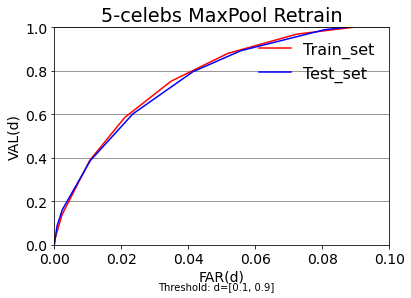

In [57]:
metrics_train = metric_obtention(trainX2) 
metrics_test  = metric_obtention(testX2)
        
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]

print("TRAIN METRICS")
print(metrics_train[-1])
print(metrics_train[-2])
print("TEST METRICS")
print(metrics_test[-1])
print(metrics_test[-2])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.xaxis.set_ticks_position('top')
plt.title('5-celebs MaxPool Retrain')
plt.suptitle('Threshold: d=[0.1, 0.9]',fontsize=10, y=0)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR(d)', fontsize=14)
plt.ylabel('VAL(d)', fontsize=14)
plt.xlim(0,0.1)
plt.ylim(0,1)
#ax.invert_xaxis()
ax.plot(metrics_train[-1], metrics_train[-2], 'g-', linewidth = 1.5, color='red', label='Train_set')
ax.plot(metrics_test[-1], metrics_test[-2], 'g-', linewidth = 1.5, color='blue', label='Test_set')
ax.legend(loc='upper right', frameon=False)
plt.savefig('../data/curves/retrained/5_celebs_maxpool_retrained.png')
plt.show()

# LFW - MaxPool Retrained

In [58]:
data = np.load("../data/datasets/custom_lfw.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)


In [59]:
data = np.load("../data/datasets/custom_lfw.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "../models/facenet_keras_maxpool_retrain.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('../data/datasets/custom_lfw_embeddings.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)
(594, 128)
(175, 128)


In [60]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("../data/datasets/custom_lfw_embeddings.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=594, test=175
['Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji'
 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill'
 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 

Pairs: 176121
Psame: 13114
Pdiff: 1571975
VAL para threshold: 0.1 es: 0.0020588683849321336
FAR para threshold: 0.1 es: 0.0
VAL para threshold: 0.2 es: 0.052691779777337196
FAR para threshold: 0.2 es: 5.279982188011896e-05
VAL para threshold: 0.30000000000000004 es: 0.2256367241116364
FAR para threshold: 0.30000000000000004 es: 0.0004650201180044212
VAL para threshold: 0.4 es: 0.4598901936861369
FAR para threshold: 0.4 es: 0.0014421348940027673
VAL para threshold: 0.5 es: 0.6680646637181638
FAR para threshold: 0.5 es: 0.0028314699661254154
VAL para threshold: 0.6 es: 0.8083727314320573
FAR para threshold: 0.6 es: 0.004294597560393772
VAL para threshold: 0.7000000000000001 es: 0.8900411773676986
FAR para threshold: 0.7000000000000001 es: 0.005657214650360216
VAL para threshold: 0.8 es: 0.95531493060851
FAR para threshold: 0.8 es: 0.007563097377502823
VAL para threshold: 0.9 es: 1.0
FAR para threshold: 0.9 es: 0.010545333100081109
Pairs: 15225
Psame: 878
Pdiff: 136147
VAL para threshold:

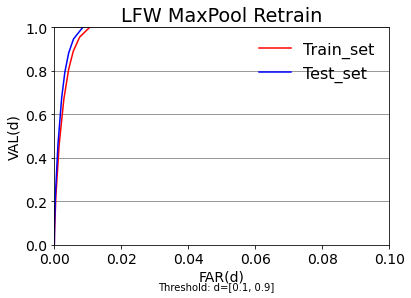

In [61]:
metrics_train = metric_obtention(trainX2) 
metrics_test  = metric_obtention(testX2)
        
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]

print("TRAIN METRICS")
print(metrics_train[-2])
print(metrics_train[-1])
print("TEST METRICS")
print(metrics_test[-2])
print(metrics_test[-1])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.xaxis.set_ticks_position('top')
plt.title('LFW MaxPool Retrain')
plt.suptitle('Threshold: d=[0.1, 0.9]',fontsize=10, y=0)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR(d)', fontsize=14)
plt.ylabel('VAL(d)', fontsize=14)
plt.xlim(0,0.1)
plt.ylim(0,1)
#ax.invert_xaxis()
ax.plot(metrics_train[-1], metrics_train[-2], 'g-', linewidth = 1.5, color='red', label='Train_set')
ax.plot(metrics_test[-1], metrics_test[-2], 'g-', linewidth = 1.5, color='blue', label='Test_set')
ax.legend(loc='upper right', frameon=False)
plt.savefig('../data/curves/retrained/lfw_maxpool_retrained.png')
plt.show()

# Outliers - MaxPool Retrained

In [62]:
data = np.load("../data/datasets/5_celebs_outliers.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

Loaded:  (100, 160, 160, 3) (100,) (38, 160, 160, 3) (38,)


In [63]:
data = np.load("../data/datasets/5_celebs_outliers.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "../models/facenet_keras_maxpool_retrain.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('../data/datasets/5_celebs_outliers_embeddings.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (100, 160, 160, 3) (100,) (38, 160, 160, 3) (38,)
(100, 128)
(38, 128)


In [64]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("../data/datasets/5_celebs_outliers_embeddings.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=100, test=38
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld'

Pairs: 4950
Psame: 2767
Pdiff: 41783
VAL para threshold: 0.1 es: 0.026020961329960245
FAR para threshold: 0.1 es: 0.0
VAL para threshold: 0.2 es: 0.04915070473436935
FAR para threshold: 0.2 es: 0.0001914654285235622
VAL para threshold: 0.30000000000000004 es: 0.18070112034694616
FAR para threshold: 0.30000000000000004 es: 0.002680515999329871
VAL para threshold: 0.4 es: 0.41488977231658836
FAR para threshold: 0.4 es: 0.010434865854534141
VAL para threshold: 0.5 es: 0.597397903867004
FAR para threshold: 0.5 es: 0.020103869994974034
VAL para threshold: 0.6 es: 0.7593061076978678
FAR para threshold: 0.6 es: 0.03350644999162339
VAL para threshold: 0.7000000000000001 es: 0.8839898807372606
FAR para threshold: 0.7000000000000001 es: 0.05002034320178063
VAL para threshold: 0.8 es: 0.9692808095410191
FAR para threshold: 0.8 es: 0.06978914869683843
VAL para threshold: 0.9 es: 1.0
FAR para threshold: 0.9 es: 0.08606371012134122
Pairs: 703
Psame: 290
Pdiff: 6037
VAL para threshold: 0.1 es: 0.1551

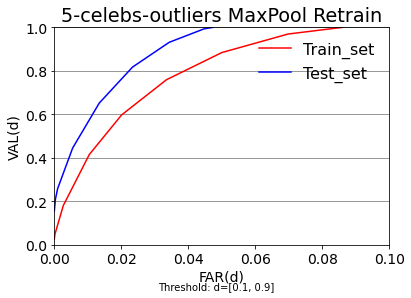

In [65]:
metrics_train = metric_obtention(trainX2) 
metrics_test  = metric_obtention(testX2)
        
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]

print("TRAIN METRICS")
print(metrics_train[-2])
print(metrics_train[-1])
print("TEST METRICS")
print(metrics_test[-2])
print(metrics_test[-1])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.xaxis.set_ticks_position('top')
plt.title('5-celebs-outliers MaxPool Retrain')
plt.suptitle('Threshold: d=[0.1, 0.9]',fontsize=10, y=0)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR(d)', fontsize=14)
plt.ylabel('VAL(d)', fontsize=14)
plt.xlim(0,0.1)
plt.ylim(0,1)
#ax.invert_xaxis()
ax.plot(metrics_train[-1], metrics_train[-2], 'g-', linewidth = 1.5, color='red', label='Train_set')
ax.plot(metrics_test[-1], metrics_test[-2], 'g-', linewidth = 1.5, color='blue', label='Test_set')
ax.legend(loc='upper right', frameon=False)
plt.savefig('../data/curves/retrained/5_celebs_outliers_maxpool_retrained.png')
plt.show()

# Format - MaxPool Retrained

In [66]:
data = np.load("../data/datasets/5_celebs_format.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

Loaded:  (100, 160, 160, 3) (100,) (26, 160, 160, 3) (26,)


In [67]:
data = np.load("../data/datasets/5_celebs_format.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "../models/facenet_keras_maxpool_retrain.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('../data/datasets/5_celebs_format_embeddings.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (100, 160, 160, 3) (100,) (26, 160, 160, 3) (26,)
(100, 128)
(26, 128)


In [68]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("../data/datasets/5_celebs_format_embeddings.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=100, test=26
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld

Pairs: 4950
Psame: 3062
Pdiff: 41488
VAL para threshold: 0.1 es: 0.047028086218158065
FAR para threshold: 0.1 es: 0.0
VAL para threshold: 0.2 es: 0.06792945787067277
FAR para threshold: 0.2 es: 0.0001928268414963363
VAL para threshold: 0.30000000000000004 es: 0.1845199216198563
FAR para threshold: 0.30000000000000004 es: 0.002651369070574624
VAL para threshold: 0.4 es: 0.4392553886348792
FAR para threshold: 0.4 es: 0.012051677593521017
VAL para threshold: 0.5 es: 0.6319399085564991
FAR para threshold: 0.5 es: 0.02342846124180486
VAL para threshold: 0.6 es: 0.7769431743958197
FAR para threshold: 0.6 es: 0.03680582337061319
VAL para threshold: 0.7000000000000001 es: 0.8954931417374266
FAR para threshold: 0.7000000000000001 es: 0.054304859236405705
VAL para threshold: 0.8 es: 0.969301110385369
FAR para threshold: 0.8 es: 0.07337061318935596
VAL para threshold: 0.9 es: 1.0
FAR para threshold: 0.9 es: 0.09149633629001157
Pairs: 325
Psame: 232
Pdiff: 2693
VAL para threshold: 0.1 es: 0.155172

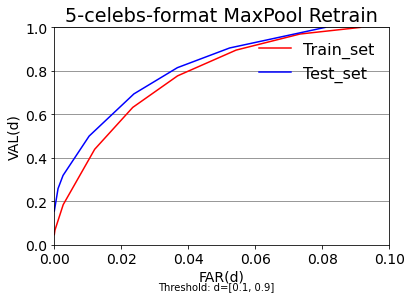

In [69]:
metrics_train = metric_obtention(trainX2) 
metrics_test  = metric_obtention(testX2)
        
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]

print("TRAIN METRICS")
print(metrics_train[-2])
print(metrics_train[-1])
print("TEST METRICS")
print(metrics_test[-2])
print(metrics_test[-1])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.xaxis.set_ticks_position('top')
plt.title('5-celebs-format MaxPool Retrain')
plt.suptitle('Threshold: d=[0.1, 0.9]',fontsize=10, y=0)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR(d)', fontsize=14)
plt.ylabel('VAL(d)', fontsize=14)
plt.xlim(0,0.1)
plt.ylim(0,1)
#ax.invert_xaxis()
ax.plot(metrics_train[-1], metrics_train[-2], 'g-', linewidth = 1.5, color='red', label='Train_set')
ax.plot(metrics_test[-1], metrics_test[-2], 'g-', linewidth = 1.5, color='blue', label='Test_set')
ax.legend(loc='upper right', frameon=False)
plt.savefig('../data/curves/retrained/5_celebs_format_maxpool_retrained.png')
plt.show()

# All-datasets - MaxPool Retrained

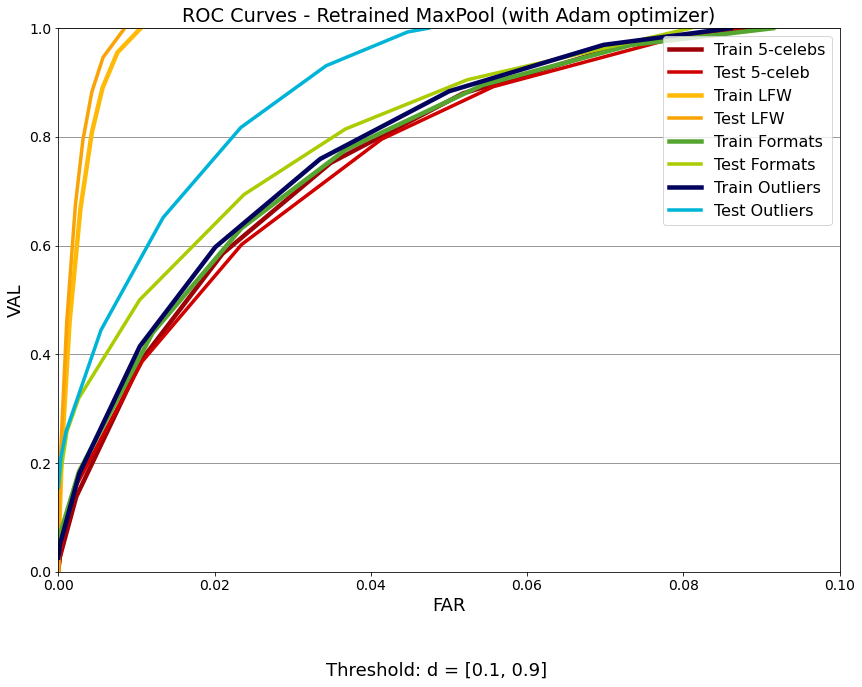

In [19]:
max_celebs_val_train = [0.0037593984962406013, 0.027151211361737676, 0.13826232247284878, 0.3888888888888889, 0.5852130325814536, 0.752297410192147, 0.8801169590643275, 0.968671679197995, 1.0]
max_celebs_far_train = [0.0, 0.000193862855876814, 0.0022986595768250805, 0.010607067685831395, 0.021020272515785976, 0.03486761936412983, 0.05181677190650271, 0.072366234629445, 0.08898305084745763]
max_celebs_val_val = [0.0, 0.08602150537634409, 0.16129032258064516, 0.3870967741935484, 0.6021505376344086, 0.7956989247311828, 0.8924731182795699, 0.989247311827957, 1.0]
max_celebs_far_val = [0.0, 0.0007955449482895784, 0.002386634844868735, 0.010739856801909307, 0.023468575974542563, 0.04136833731105807, 0.05568814638027048, 0.0807478122513922, 0.08711217183770883]

max_format_val_train = [0.047028086218158065, 0.06792945787067277, 0.1845199216198563, 0.4392553886348792, 0.6319399085564991, 0.7769431743958197, 0.8954931417374266, 0.969301110385369, 1.0]
max_format_far_train = [0.0, 0.0001928268414963363, 0.002651369070574624, 0.012051677593521017, 0.02342846124180486, 0.03680582337061319, 0.054304859236405705, 0.07337061318935596, 0.09149633629001157]
max_format_val_val = [0.15517241379310345, 0.25862068965517243, 0.31896551724137934, 0.5, 0.6939655172413793, 0.8146551724137931, 0.9051724137931034, 1.0, 1.0]
max_format_far_val = [0.0, 0.0011139992573338284, 0.0025993316004456, 0.0103973264017824, 0.02376531748978834, 0.03676197549201634, 0.052357965094689936, 0.08095061269959153, 0.08095061269959153]

max_lfw_val_train = [0.0020588683849321336, 0.052691779777337196, 0.2256367241116364, 0.4598901936861369, 0.6680646637181638, 0.8083727314320573, 0.8900411773676986, 0.95531493060851, 1.0]
max_lfw_far_train = [0.0, 5.279982188011896e-05, 0.0004650201180044212, 0.0014421348940027673, 0.0028314699661254154, 0.004294597560393772, 0.005657214650360216, 0.007563097377502823, 0.010545333100081109]
max_lfw_val_val = [0.0, 0.09111617312072894, 0.2266514806378132, 0.45899772209567197, 0.6753986332574032, 0.7938496583143508, 0.8826879271070615, 0.9464692482915718, 1.0]
max_lfw_far_val = [0.0, 7.345002093325597e-05, 0.00032318009210632626, 0.001072370305625537, 0.002188810623811028, 0.0031436608959433555, 0.004289481222502148, 0.005729101632793965, 0.00849082241988439]

max_outliers_val_train = [0.026020961329960245, 0.04915070473436935, 0.18070112034694616, 0.41488977231658836, 0.597397903867004, 0.7593061076978678, 0.8839898807372606, 0.9692808095410191, 1.0]
max_outliers_far_train = [0.0, 0.0001914654285235622, 0.002680515999329871, 0.010434865854534141, 0.020103869994974034, 0.03350644999162339, 0.05002034320178063, 0.06978914869683843, 0.08606371012134122]
max_outliers_val_val = [0.15517241379310345, 0.2103448275862069, 0.25862068965517243, 0.44482758620689655, 0.6517241379310345, 0.8172413793103448, 0.9310344827586207, 0.993103448275862, 1.0]
max_outliers_far_val = [0.0, 0.00033129037601457677, 0.0009938711280437303, 0.005466291204240517, 0.013417260228590359, 0.023355971509027663, 0.03428855391750869, 0.04472420076196786, 0.04737452377008448]

fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(1, 1, 1)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR', fontsize=14)
plt.ylabel('VAL', fontsize=14)
plt.xlim(0,0.015)
plt.ylim(0,1)
ax.plot(max_celebs_far_train, max_celebs_val_train, '#9D0208', linewidth = 4.5, label = "Train 5-celebs") # red
ax.plot(max_celebs_far_val, max_celebs_val_val, "#D00000", linewidth = 3.5, label= "Test 5-celeb")

ax.plot(max_lfw_far_train, max_lfw_val_train, '#FFBA08', linewidth = 4.5, label = "Train LFW") # yellow
ax.plot(max_lfw_far_val, max_lfw_val_val, "#FAA307", linewidth = 3.5, label = "Test LFW")

ax.plot(max_format_far_train, max_format_val_train, '#55A630', linewidth = 4.5, label = "Train Formats") # Green RYB
ax.plot(max_format_far_val, max_format_val_val, "#AACC00", linewidth = 3.5, label = "Test Formats") # Android green

ax.plot(max_outliers_far_train, max_outliers_val_train, '#03045E', linewidth = 4.5, label = "Train Outliers") #Navy Blue
ax.plot(max_outliers_far_val, max_outliers_val_val, "#00B4D8", linewidth = 3.5, label = "Test Outliers") # Cyan

plt.rcParams.update({'font.size': 16})
plt.legend(loc = "upper right")
plt.title("ROC Curves - Retrained MaxPool (with Adam optimizer)")
plt.ylabel("VAL", fontsize = 18)
plt.xlabel("FAR", fontsize = 18)
plt.suptitle('Threshold: d = [0.1, 0.9]',fontsize=18, y=0)
plt.xlim(0,0.1)
plt.ylim(0,1)
plt.savefig('../data/curves/retrained/all_datasets_maxpool_adam_retrained.png')
plt.show()

# 5-celebs - MaxPool & Dropout Retrained

In [20]:
data = np.load("../data/datasets/5-celebrity-faces-dataset.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [21]:
data = np.load("../data/datasets/5-celebrity-faces-dataset.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "../models/facenet_keras_maxpool_dropout_double_retrain.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('../data/datasets/5-celebrity-faces-dataset-embeddings.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)
(93, 128)
(25, 128)


In [22]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("../data/datasets/5-celebrity-faces-dataset-embeddings.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=93, test=25
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'mindy_k

Pairs: 4278
Psame: 2394
Pdiff: 36108
VAL para threshold: 0.1 es: 0.0037593984962406013
FAR para threshold: 0.1 es: 0.0
VAL para threshold: 0.2 es: 0.027151211361737676
FAR para threshold: 0.2 es: 0.000193862855876814
VAL para threshold: 0.30000000000000004 es: 0.13826232247284878
FAR para threshold: 0.30000000000000004 es: 0.0022986595768250805
VAL para threshold: 0.4 es: 0.3888888888888889
FAR para threshold: 0.4 es: 0.010607067685831395
VAL para threshold: 0.5 es: 0.5852130325814536
FAR para threshold: 0.5 es: 0.021020272515785976
VAL para threshold: 0.6 es: 0.752297410192147
FAR para threshold: 0.6 es: 0.03486761936412983
VAL para threshold: 0.7000000000000001 es: 0.8801169590643275
FAR para threshold: 0.7000000000000001 es: 0.05181677190650271
VAL para threshold: 0.8 es: 0.968671679197995
FAR para threshold: 0.8 es: 0.072366234629445
VAL para threshold: 0.9 es: 1.0
FAR para threshold: 0.9 es: 0.08898305084745763
Pairs: 300
Psame: 186
Pdiff: 2514
VAL para threshold: 0.1 es: 0.0
FAR 

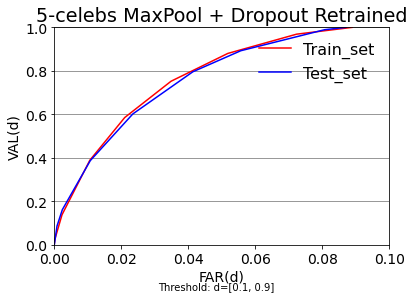

In [23]:
metrics_train = metric_obtention(trainX2) 
metrics_test  = metric_obtention(testX2)
        
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]

print("TRAIN METRICS")
print(metrics_train[-1])
print(metrics_train[-2])
print("TEST METRICS")
print(metrics_test[-1])
print(metrics_test[-2])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.xaxis.set_ticks_position('top')
plt.title('5-celebs MaxPool + Dropout Retrained')
plt.suptitle('Threshold: d=[0.1, 0.9]',fontsize=10, y=0)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR(d)', fontsize=14)
plt.ylabel('VAL(d)', fontsize=14)
plt.xlim(0,0.1)
plt.ylim(0,1)
#ax.invert_xaxis()
ax.plot(metrics_train[-1], metrics_train[-2], 'g-', linewidth = 1.5, color='red', label='Train_set')
ax.plot(metrics_test[-1], metrics_test[-2], 'g-', linewidth = 1.5, color='blue', label='Test_set')
ax.legend(loc='upper right', frameon=False)
plt.savefig('../data/curves/retrained/5_celebs_maxpool_dropout_double_retrain.png')
plt.show()

# LFW - MaxPool Retrained

In [24]:
data = np.load("../data/datasets/custom_lfw.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)


In [25]:
data = np.load("../data/datasets/custom_lfw.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "../models/facenet_keras_maxpool_dropout_double_retrain.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('../data/datasets/custom_lfw_embeddings.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (594, 160, 160, 3) (594,) (175, 160, 160, 3) (175,)
(594, 128)
(175, 128)


In [26]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("../data/datasets/custom_lfw_embeddings.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=594, test=175
['Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Mark_Philippoussis'
 'Mark_Philippoussis' 'Mark_Philippoussis' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka' 'Heizo_Takenaka'
 'Heizo_Takenaka' 'Heizo_Takenaka' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji'
 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Zhu_Rongji' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro' 'Fidel_Castro'
 'Fidel_Castro' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill'
 'Paul_ONeill' 'Paul_ONeill' 'Paul_ONeill' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford'
 'Harrison_Ford' 'Harrison_Ford' 'Harrison_Ford' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake' 'James_Blake'
 'James_Blake' 'James_Blake' 'James_Blake' 

Pairs: 176121
Psame: 13114
Pdiff: 1571975
VAL para threshold: 0.1 es: 0.0020588683849321336
FAR para threshold: 0.1 es: 0.0
VAL para threshold: 0.2 es: 0.052691779777337196
FAR para threshold: 0.2 es: 5.279982188011896e-05
VAL para threshold: 0.30000000000000004 es: 0.2256367241116364
FAR para threshold: 0.30000000000000004 es: 0.0004650201180044212
VAL para threshold: 0.4 es: 0.4598901936861369
FAR para threshold: 0.4 es: 0.0014421348940027673
VAL para threshold: 0.5 es: 0.6680646637181638
FAR para threshold: 0.5 es: 0.0028314699661254154
VAL para threshold: 0.6 es: 0.8083727314320573
FAR para threshold: 0.6 es: 0.004294597560393772
VAL para threshold: 0.7000000000000001 es: 0.8900411773676986
FAR para threshold: 0.7000000000000001 es: 0.005657214650360216
VAL para threshold: 0.8 es: 0.95531493060851
FAR para threshold: 0.8 es: 0.007563097377502823
VAL para threshold: 0.9 es: 1.0
FAR para threshold: 0.9 es: 0.010545333100081109
Pairs: 15225
Psame: 878
Pdiff: 136147
VAL para threshold:

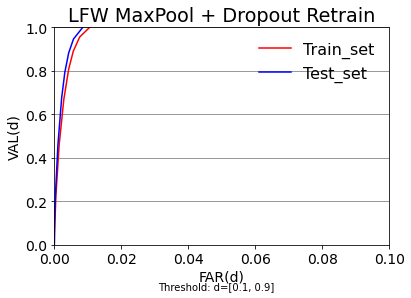

In [27]:
metrics_train = metric_obtention(trainX2) 
metrics_test  = metric_obtention(testX2)
        
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]

print("TRAIN METRICS")
print(metrics_train[-2])
print(metrics_train[-1])
print("TEST METRICS")
print(metrics_test[-2])
print(metrics_test[-1])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.xaxis.set_ticks_position('top')
plt.title('LFW MaxPool + Dropout Retrain')
plt.suptitle('Threshold: d=[0.1, 0.9]',fontsize=10, y=0)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR(d)', fontsize=14)
plt.ylabel('VAL(d)', fontsize=14)
plt.xlim(0,0.1)
plt.ylim(0,1)
#ax.invert_xaxis()
ax.plot(metrics_train[-1], metrics_train[-2], 'g-', linewidth = 1.5, color='red', label='Train_set')
ax.plot(metrics_test[-1], metrics_test[-2], 'g-', linewidth = 1.5, color='blue', label='Test_set')
ax.legend(loc='upper right', frameon=False)
plt.savefig('../data/curves/retrained/lfw_maxpool_dropout_double_retrain.png')
plt.show()

# Outliers - MaxPool + Dropout Retrained

In [28]:
data = np.load("../data/datasets/5_celebs_outliers.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

Loaded:  (100, 160, 160, 3) (100,) (38, 160, 160, 3) (38,)


In [29]:
data = np.load("../data/datasets/5_celebs_outliers.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "../models/facenet_keras_maxpool_dropout_double_retrain.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('../data/datasets/5_celebs_outliers_embeddings.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (100, 160, 160, 3) (100,) (38, 160, 160, 3) (38,)
(100, 128)
(38, 128)


In [30]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("../data/datasets/5_celebs_outliers_embeddings.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=100, test=38
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld'

Pairs: 4950
Psame: 2767
Pdiff: 41783
VAL para threshold: 0.1 es: 0.026020961329960245
FAR para threshold: 0.1 es: 0.0
VAL para threshold: 0.2 es: 0.04915070473436935
FAR para threshold: 0.2 es: 0.0001914654285235622
VAL para threshold: 0.30000000000000004 es: 0.18070112034694616
FAR para threshold: 0.30000000000000004 es: 0.002680515999329871
VAL para threshold: 0.4 es: 0.41488977231658836
FAR para threshold: 0.4 es: 0.010434865854534141
VAL para threshold: 0.5 es: 0.597397903867004
FAR para threshold: 0.5 es: 0.020103869994974034
VAL para threshold: 0.6 es: 0.7593061076978678
FAR para threshold: 0.6 es: 0.03350644999162339
VAL para threshold: 0.7000000000000001 es: 0.8839898807372606
FAR para threshold: 0.7000000000000001 es: 0.05002034320178063
VAL para threshold: 0.8 es: 0.9692808095410191
FAR para threshold: 0.8 es: 0.06978914869683843
VAL para threshold: 0.9 es: 1.0
FAR para threshold: 0.9 es: 0.08606371012134122
Pairs: 703
Psame: 290
Pdiff: 6037
VAL para threshold: 0.1 es: 0.1551

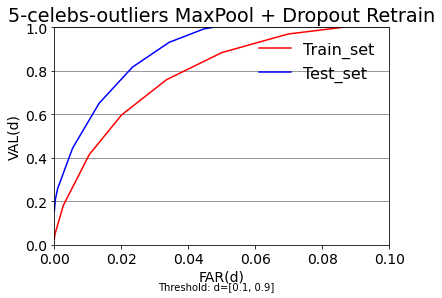

In [31]:
metrics_train = metric_obtention(trainX2) 
metrics_test  = metric_obtention(testX2)
        
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]

print("TRAIN METRICS")
print(metrics_train[-2])
print(metrics_train[-1])
print("TEST METRICS")
print(metrics_test[-2])
print(metrics_test[-1])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.xaxis.set_ticks_position('top')
plt.title('5-celebs-outliers MaxPool + Dropout Retrain')
plt.suptitle('Threshold: d=[0.1, 0.9]',fontsize=10, y=0)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR(d)', fontsize=14)
plt.ylabel('VAL(d)', fontsize=14)
plt.xlim(0,0.1)
plt.ylim(0,1)
#ax.invert_xaxis()
ax.plot(metrics_train[-1], metrics_train[-2], 'g-', linewidth = 1.5, color='red', label='Train_set')
ax.plot(metrics_test[-1], metrics_test[-2], 'g-', linewidth = 1.5, color='blue', label='Test_set')
ax.legend(loc='upper right', frameon=False)
plt.savefig('../data/curves/retrained/5_celebs_outliers_maxpool_dropout_double_retrain.png')
plt.show()

# Format - MaxPool + Dropout Retrain

In [32]:
data = np.load("../data/datasets/5_celebs_format.npz")

raw_trainX, raw_trainy, raw_testX, raw_testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", raw_trainX.shape, raw_trainy.shape, raw_testX.shape, raw_testy.shape)

Loaded:  (100, 160, 160, 3) (100,) (26, 160, 160, 3) (26,)


In [33]:
data = np.load("../data/datasets/5_celebs_format.npz")

trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Loaded: ", trainX.shape, trainy.shape, testX.shape, testy.shape)

path_to_model = "../models/facenet_keras_maxpool_dropout_double_retrain.h5"
model = load_model(path_to_model)

newTrainX = list()
for face_pixels in trainX:
    embedding = get_embedding(model, face_pixels)
    newTrainX.append(embedding)
newTrainX = np.asarray(newTrainX)
print(newTrainX.shape)

newTestX = list()
for face_pixels in testX:
    embedding = get_embedding(model, face_pixels)
    newTestX.append(embedding)
newTestX = np.asarray(newTestX)
print(newTestX.shape)

np.savez_compressed('../data/datasets/5_celebs_format_embeddings.npz',newTrainX, trainy, newTestX, testy)

Loaded:  (100, 160, 160, 3) (100,) (26, 160, 160, 3) (26,)
(100, 128)
(26, 128)


In [34]:
from sklearn.preprocessing import Normalizer, LabelEncoder

# 1) Load dataset
data = np.load("../data/datasets/5_celebs_format_embeddings.npz")
trainX, trainy, testX, testy = data["arr_0"], data["arr_1"], data["arr_2"], data["arr_3"]
print("Dataset: train=%d, test=%d" % (trainX.shape[0], testX.shape[0]))

# 2) Normalize input vectors
in_encoder = Normalizer(norm = "l2")
#print(trainX[0]) # Embedding without normalization
normed_trainX = in_encoder.transform(trainX)
#print(trainX[0]) # Embedding with normalization
normed_testX = in_encoder.transform(testX)

# 3) Label encode targets
out_encoder = LabelEncoder()
print(trainy)
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
print(trainy)
testy = out_encoder.transform(testy)

# Create embedding with it's own photo

count = 0
trainX2 = list()
for face in normed_trainX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    trainX2.append(new_emb)
    count += 1

count = 0
testX2 = list()
for face in normed_testX:
    new_emb = face
    new_emb = np.append(new_emb, count)
    #print(trainy[count])
    #print(new_emb)
    testX2.append(new_emb)
    count += 1


Dataset: train=100, test=26
['ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek'
 'ben_afflek' 'ben_afflek' 'ben_afflek' 'ben_afflek' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'elton_john' 'elton_john'
 'elton_john' 'elton_john' 'elton_john' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna' 'madonna'
 'madonna' 'madonna' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld' 'jerry_seinfeld'
 'jerry_seinfeld

Pairs: 4950
Psame: 3062
Pdiff: 41488
VAL para threshold: 0.1 es: 0.047028086218158065
FAR para threshold: 0.1 es: 0.0
VAL para threshold: 0.2 es: 0.06792945787067277
FAR para threshold: 0.2 es: 0.0001928268414963363
VAL para threshold: 0.30000000000000004 es: 0.1845199216198563
FAR para threshold: 0.30000000000000004 es: 0.002651369070574624
VAL para threshold: 0.4 es: 0.4392553886348792
FAR para threshold: 0.4 es: 0.012051677593521017
VAL para threshold: 0.5 es: 0.6319399085564991
FAR para threshold: 0.5 es: 0.02342846124180486
VAL para threshold: 0.6 es: 0.7769431743958197
FAR para threshold: 0.6 es: 0.03680582337061319
VAL para threshold: 0.7000000000000001 es: 0.8954931417374266
FAR para threshold: 0.7000000000000001 es: 0.054304859236405705
VAL para threshold: 0.8 es: 0.969301110385369
FAR para threshold: 0.8 es: 0.07337061318935596
VAL para threshold: 0.9 es: 1.0
FAR para threshold: 0.9 es: 0.09149633629001157
Pairs: 325
Psame: 232
Pdiff: 2693
VAL para threshold: 0.1 es: 0.155172

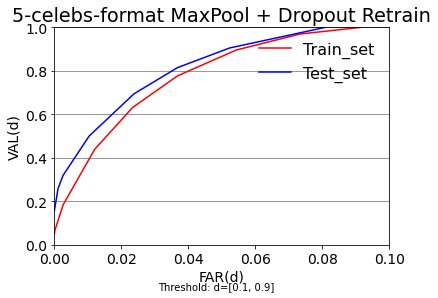

In [35]:
metrics_train = metric_obtention(trainX2) 
metrics_test  = metric_obtention(testX2)
        
# metrics = [pairs, Psame, Pdiff, TA_total, FA_total, VAL_list, FAR_list]

print("TRAIN METRICS")
print(metrics_train[-2])
print(metrics_train[-1])
print("TEST METRICS")
print(metrics_test[-2])
print(metrics_test[-1])

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
#ax.xaxis.set_ticks_position('top')
plt.title('5-celebs-format MaxPool + Dropout Retrain')
plt.suptitle('Threshold: d=[0.1, 0.9]',fontsize=10, y=0)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR(d)', fontsize=14)
plt.ylabel('VAL(d)', fontsize=14)
plt.xlim(0,0.1)
plt.ylim(0,1)
#ax.invert_xaxis()
ax.plot(metrics_train[-1], metrics_train[-2], 'g-', linewidth = 1.5, color='red', label='Train_set')
ax.plot(metrics_test[-1], metrics_test[-2], 'g-', linewidth = 1.5, color='blue', label='Test_set')
ax.legend(loc='upper right', frameon=False)
plt.savefig('../data/curves/retrained/5_celebs_format_maxpool_dropout_double_retrain.png')
plt.show()

# All-datasets - MaxPool + Dropout Retrained

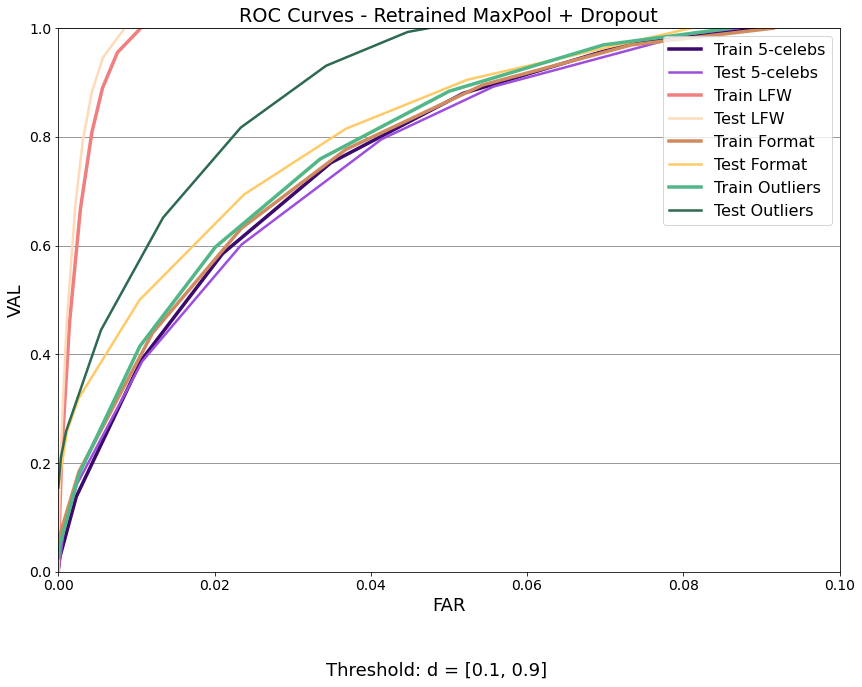

In [36]:
drop_celebs_val_train = [0.0037593984962406013, 0.027151211361737676, 0.13826232247284878, 0.3888888888888889, 0.5852130325814536, 0.752297410192147, 0.8801169590643275, 0.968671679197995, 1.0]
drop_celebs_far_train = [0.0, 0.000193862855876814, 0.0022986595768250805, 0.010607067685831395, 0.021020272515785976, 0.03486761936412983, 0.05181677190650271, 0.072366234629445, 0.08898305084745763]
drop_celebs_val_val = [0.0, 0.08602150537634409, 0.16129032258064516, 0.3870967741935484, 0.6021505376344086, 0.7956989247311828, 0.8924731182795699, 0.989247311827957, 1.0]
drop_celebs_far_val = [0.0, 0.0007955449482895784, 0.002386634844868735, 0.010739856801909307, 0.023468575974542563, 0.04136833731105807, 0.05568814638027048, 0.0807478122513922, 0.08711217183770883]

drop_format_val_train = [0.047028086218158065, 0.06792945787067277, 0.1845199216198563, 0.4392553886348792, 0.6319399085564991, 0.7769431743958197, 0.8954931417374266, 0.969301110385369, 1.0]
drop_format_far_train = [0.0, 0.0001928268414963363, 0.002651369070574624, 0.012051677593521017, 0.02342846124180486, 0.03680582337061319, 0.054304859236405705, 0.07337061318935596, 0.09149633629001157]
drop_format_val_val = [0.15517241379310345, 0.25862068965517243, 0.31896551724137934, 0.5, 0.6939655172413793, 0.8146551724137931, 0.9051724137931034, 1.0, 1.0]
drop_format_far_val = [0.0, 0.0011139992573338284, 0.0025993316004456, 0.0103973264017824, 0.02376531748978834, 0.03676197549201634, 0.052357965094689936, 0.08095061269959153, 0.08095061269959153]

drop_lfw_val_train = [0.0020588683849321336, 0.052691779777337196, 0.2256367241116364, 0.4598901936861369, 0.6680646637181638, 0.8083727314320573, 0.8900411773676986, 0.95531493060851, 1.0]
drop_lfw_far_train = [0.0, 5.279982188011896e-05, 0.0004650201180044212, 0.0014421348940027673, 0.0028314699661254154, 0.004294597560393772, 0.005657214650360216, 0.007563097377502823, 0.010545333100081109]
drop_lfw_val_val = [0.0, 0.09111617312072894, 0.2266514806378132, 0.45899772209567197, 0.6753986332574032, 0.7938496583143508, 0.8826879271070615, 0.9464692482915718, 1.0]
drop_lfw_far_val = [0.0, 7.345002093325597e-05, 0.00032318009210632626, 0.001072370305625537, 0.002188810623811028, 0.0031436608959433555, 0.004289481222502148, 0.005729101632793965, 0.00849082241988439]

drop_outliers_val_train = [0.026020961329960245, 0.04915070473436935, 0.18070112034694616, 0.41488977231658836, 0.597397903867004, 0.7593061076978678, 0.8839898807372606, 0.9692808095410191, 1.0]
drop_outliers_far_train = [0.0, 0.0001914654285235622, 0.002680515999329871, 0.010434865854534141, 0.020103869994974034, 0.03350644999162339, 0.05002034320178063, 0.06978914869683843, 0.08606371012134122]
drop_outliers_val_val = [0.15517241379310345, 0.2103448275862069, 0.25862068965517243, 0.44482758620689655, 0.6517241379310345, 0.8172413793103448, 0.9310344827586207, 0.993103448275862, 1.0]
drop_outliers_far_val = [0.0, 0.00033129037601457677, 0.0009938711280437303, 0.005466291204240517, 0.013417260228590359, 0.023355971509027663, 0.03428855391750869, 0.04472420076196786, 0.04737452377008448]

fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(1, 1, 1)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR', fontsize=14)
plt.ylabel('VAL', fontsize=14)
plt.xlim(0,0.015)
plt.ylim(0,1)

ax.plot(drop_celebs_far_train, drop_celebs_val_train, '#3C096C', linewidth = 3.5, label = "Train 5-celebs") # indigo
ax.plot(drop_celebs_far_val, drop_celebs_val_val, '#9D4EDD', linewidth = 2.5, label = "Test 5-celebs") # dark orchid

ax.plot(drop_lfw_far_train, drop_lfw_val_train, '#F08080', linewidth = 3.5, label = "Train LFW") # Light coral
ax.plot(drop_lfw_far_val, drop_lfw_val_val, '#FFDAB9', linewidth = 2.5, label = "Test LFW") # Peach Puff

ax.plot(drop_format_far_train, drop_format_val_train, '#D08C60', linewidth = 3.5, label = "Train Format") # Raw sienna
ax.plot(drop_format_far_val, drop_format_val_val, '#FFCB69', linewidth = 2.5, label = "Test Format") # Maximum yellow red

ax.plot(drop_outliers_far_train, drop_outliers_val_train, '#52B788', linewidth = 3.5, label = "Train Outliers") # Ocean Green
ax.plot(drop_outliers_far_val, drop_outliers_val_val, '#2D6A4F', linewidth = 2.5, label = "Test Outliers") # Bottle green
plt.rcParams.update({'font.size': 16})
plt.legend(loc = "upper right")
plt.title("ROC Curves - Retrained MaxPool + Dropout")
plt.ylabel("VAL", fontsize = 18)
plt.xlabel("FAR", fontsize = 18)
plt.suptitle('Threshold: d = [0.1, 0.9]',fontsize=18, y=0)
plt.xlim(0,0.1)
plt.ylim(0,1)
plt.savefig('../data/curves/retrained/all_datasets_maxpool_dropout_double_retrain.png')
plt.show()

# 5-celebs - MaxPool Retrained + MaxPool/Dropout Retrained

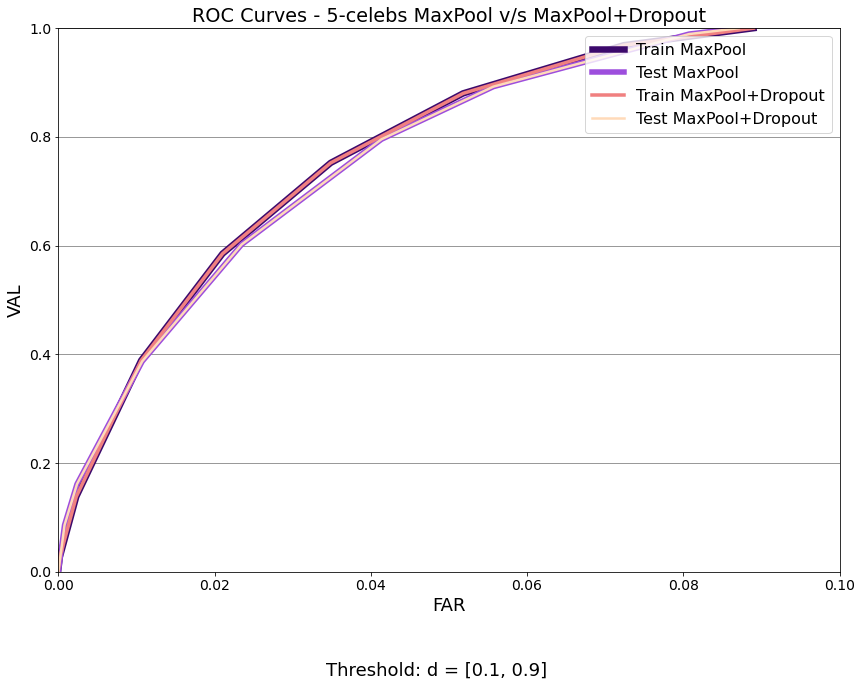

In [52]:
max_train_val = [0.0, 0.000193862855876814, 0.0022986595768250805, 0.010607067685831395, 0.021020272515785976, 0.03486761936412983, 0.05181677190650271, 0.072366234629445, 0.08898305084745763]
max_train_far = [0.0037593984962406013, 0.027151211361737676, 0.13826232247284878, 0.3888888888888889, 0.5852130325814536, 0.752297410192147, 0.8801169590643275, 0.968671679197995, 1.0]
max_test_val = [0.0, 0.0007955449482895784, 0.002386634844868735, 0.010739856801909307, 0.023468575974542563, 0.04136833731105807, 0.05568814638027048, 0.0807478122513922, 0.08711217183770883]
max_test_far = [0.0, 0.08602150537634409, 0.16129032258064516, 0.3870967741935484, 0.6021505376344086, 0.7956989247311828, 0.8924731182795699, 0.989247311827957, 1.0]

drop_train_val = [0.0, 0.000193862855876814, 0.0022986595768250805, 0.010607067685831395, 0.021020272515785976, 0.03486761936412983, 0.05181677190650271, 0.072366234629445, 0.08898305084745763]
drop_train_far = [0.0037593984962406013, 0.027151211361737676, 0.13826232247284878, 0.3888888888888889, 0.5852130325814536, 0.752297410192147, 0.8801169590643275, 0.968671679197995, 1.0]
drop_test_val = [0.0, 0.0007955449482895784, 0.002386634844868735, 0.010739856801909307, 0.023468575974542563, 0.04136833731105807, 0.05568814638027048, 0.0807478122513922, 0.08711217183770883]
drop_test_far = [0.0, 0.08602150537634409, 0.16129032258064516, 0.3870967741935484, 0.6021505376344086, 0.7956989247311828, 0.8924731182795699, 0.989247311827957, 1.0]

fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(1, 1, 1)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR', fontsize=14)
plt.ylabel('VAL', fontsize=14)
plt.xlim(0,0.015)
plt.ylim(0,1)

ax.plot(max_train_val, max_train_far, '#3C096C', linewidth = 6.5, label = "Train MaxPool") # indigo
ax.plot(max_test_val, max_test_far, '#9D4EDD', linewidth = 5.5, label = "Test MaxPool") # dark orchid

ax.plot(drop_train_val, drop_train_far, '#F08080', linewidth = 3.5, label = "Train MaxPool+Dropout") # Light coral
ax.plot(drop_test_val, drop_test_far, '#FFDAB9', linewidth = 2.5, label = "Test MaxPool+Dropout") # Peach Puff

plt.rcParams.update({'font.size': 16})
plt.legend(loc = "upper right")
plt.title("ROC Curves - 5-celebs MaxPool v/s MaxPool+Dropout")
plt.ylabel("VAL", fontsize = 18)
plt.xlabel("FAR", fontsize = 18)
plt.suptitle('Threshold: d = [0.1, 0.9]',fontsize=18, y=0)
plt.xlim(0,0.1)
plt.ylim(0,1)
plt.savefig('../data/curves/retrained/5_celebs_maxpool_vs_maxpool_dropout_retrain.png')
plt.show()

# LFW - MaxPool v/s MaxPool+Dropout

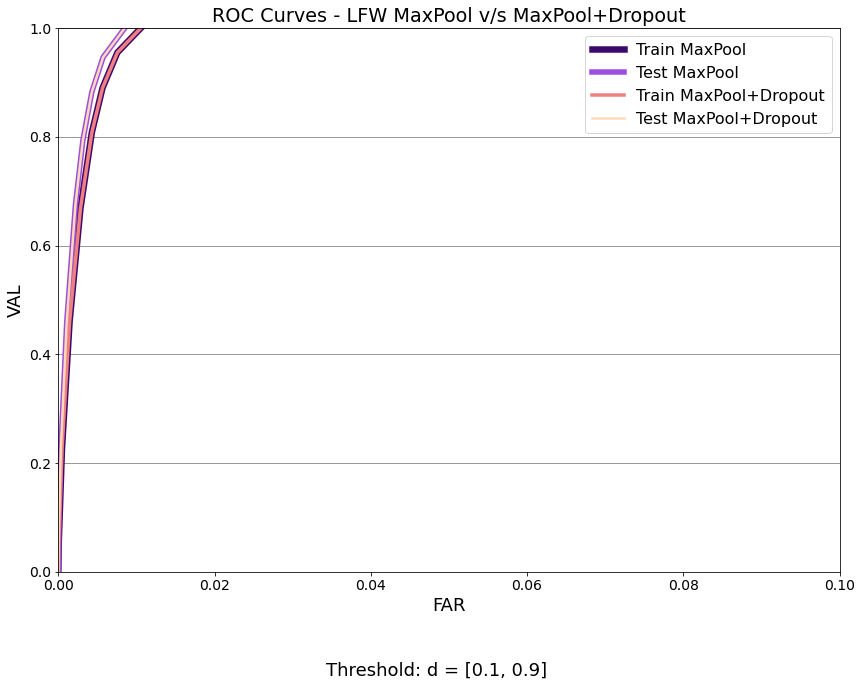

In [51]:
max_train_val = [0.0020588683849321336, 0.052691779777337196, 0.2256367241116364, 0.4598901936861369, 0.6680646637181638, 0.8083727314320573, 0.8900411773676986, 0.95531493060851, 1.0]
max_train_far = [0.0, 5.279982188011896e-05, 0.0004650201180044212, 0.0014421348940027673, 0.0028314699661254154, 0.004294597560393772, 0.005657214650360216, 0.007563097377502823, 0.010545333100081109]
max_test_val = [0.0, 0.09111617312072894, 0.2266514806378132, 0.45899772209567197, 0.6753986332574032, 0.7938496583143508, 0.8826879271070615, 0.9464692482915718, 1.0]
max_test_far = [0.0, 7.345002093325597e-05, 0.00032318009210632626, 0.001072370305625537, 0.002188810623811028, 0.0031436608959433555, 0.004289481222502148, 0.005729101632793965, 0.00849082241988439]# LFW - MaxPool v/s MaxPool+Dropout

drop_train_val = [0.0020588683849321336, 0.052691779777337196, 0.2256367241116364, 0.4598901936861369, 0.6680646637181638, 0.8083727314320573, 0.8900411773676986, 0.95531493060851, 1.0]
drop_train_far = [0.0, 5.279982188011896e-05, 0.0004650201180044212, 0.0014421348940027673, 0.0028314699661254154, 0.004294597560393772, 0.005657214650360216, 0.007563097377502823, 0.010545333100081109]
drop_test_val = [0.0, 0.09111617312072894, 0.2266514806378132, 0.45899772209567197, 0.6753986332574032, 0.7938496583143508, 0.8826879271070615, 0.9464692482915718, 1.0]
drop_test_far = [0.0, 7.345002093325597e-05, 0.00032318009210632626, 0.001072370305625537, 0.002188810623811028, 0.0031436608959433555, 0.004289481222502148, 0.005729101632793965, 0.00849082241988439]

fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(1, 1, 1)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR', fontsize=14)
plt.ylabel('VAL', fontsize=14)
plt.xlim(0,0.015)
plt.ylim(0,1)

ax.plot(max_train_far, max_train_val, '#3C096C', linewidth = 6.5, label = "Train MaxPool") # indigo
ax.plot(max_test_far, max_test_val, '#9D4EDD', linewidth = 5.5, label = "Test MaxPool") # dark orchid

ax.plot(drop_train_far, drop_train_val, '#F08080', linewidth = 3.5, label = "Train MaxPool+Dropout") # Light coral
ax.plot(drop_test_far, drop_test_val, '#FFDAB9', linewidth = 2.5, label = "Test MaxPool+Dropout") # Peach Puff

plt.rcParams.update({'font.size': 16})
plt.legend(loc = "upper right")
plt.title("ROC Curves - LFW MaxPool v/s MaxPool+Dropout")
plt.ylabel("VAL", fontsize = 18)
plt.xlabel("FAR", fontsize = 18)
plt.suptitle('Threshold: d = [0.1, 0.9]',fontsize=18, y=0)
plt.xlim(0,0.1)
plt.ylim(0,1)
plt.savefig('../data/curves/retrained/lfw_maxpool_vs_maxpool_dropout_retrain.png')
plt.show()

# Outliers - MaxPool v/s MaxPool+Dropout

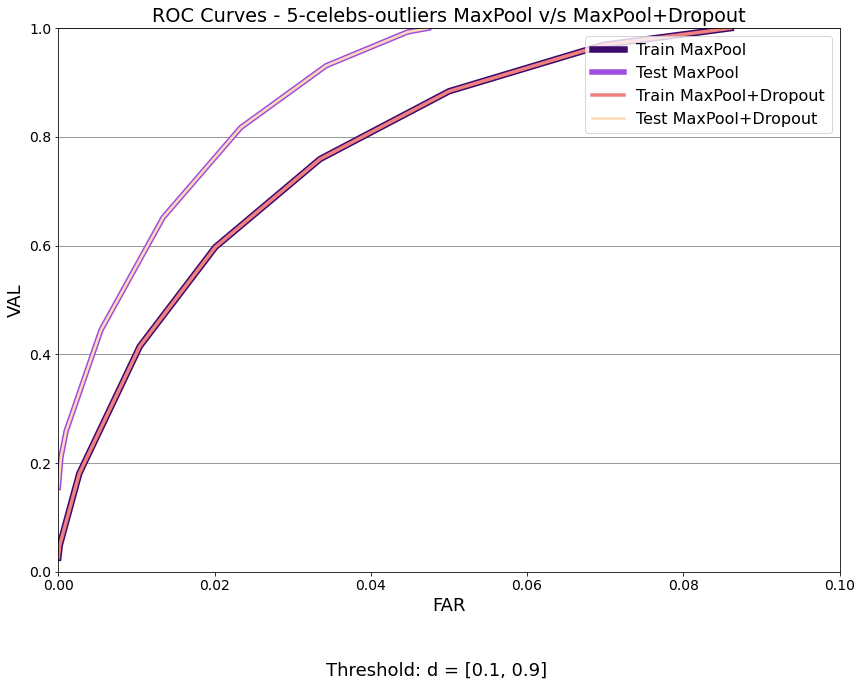

In [49]:
max_train_val = [0.026020961329960245, 0.04915070473436935, 0.18070112034694616, 0.41488977231658836, 0.597397903867004, 0.7593061076978678, 0.8839898807372606, 0.9692808095410191, 1.0]
max_train_far = [0.0, 0.0001914654285235622, 0.002680515999329871, 0.010434865854534141, 0.020103869994974034, 0.03350644999162339, 0.05002034320178063, 0.06978914869683843, 0.08606371012134122]
max_test_val = [0.15517241379310345, 0.2103448275862069, 0.25862068965517243, 0.44482758620689655, 0.6517241379310345, 0.8172413793103448, 0.9310344827586207, 0.993103448275862, 1.0]
max_test_far = [0.0, 0.00033129037601457677, 0.0009938711280437303, 0.005466291204240517, 0.013417260228590359, 0.023355971509027663, 0.03428855391750869, 0.04472420076196786, 0.04737452377008448]

drop_train_val = [0.026020961329960245, 0.04915070473436935, 0.18070112034694616, 0.41488977231658836, 0.597397903867004, 0.7593061076978678, 0.8839898807372606, 0.9692808095410191, 1.0]
drop_train_far = [0.0, 0.0001914654285235622, 0.002680515999329871, 0.010434865854534141, 0.020103869994974034, 0.03350644999162339, 0.05002034320178063, 0.06978914869683843, 0.08606371012134122]
drop_test_val = [0.15517241379310345, 0.2103448275862069, 0.25862068965517243, 0.44482758620689655, 0.6517241379310345, 0.8172413793103448, 0.9310344827586207, 0.993103448275862, 1.0]
drop_test_far = [0.0, 0.00033129037601457677, 0.0009938711280437303, 0.005466291204240517, 0.013417260228590359, 0.023355971509027663, 0.03428855391750869, 0.04472420076196786, 0.04737452377008448]

fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(1, 1, 1)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR', fontsize=14)
plt.ylabel('VAL', fontsize=14)
plt.xlim(0,0.015)
plt.ylim(0,1)

ax.plot(max_train_far, max_train_val, '#3C096C', linewidth = 6.5, label = "Train MaxPool") # indigo
ax.plot(max_test_far, max_test_val, '#9D4EDD', linewidth = 5.5, label = "Test MaxPool") # dark orchid

ax.plot(drop_train_far, drop_train_val, '#F08080', linewidth = 3.5, label = "Train MaxPool+Dropout") # Light coral
ax.plot(drop_test_far, drop_test_val, '#FFDAB9', linewidth = 2.5, label = "Test MaxPool+Dropout") # Peach Puff

plt.rcParams.update({'font.size': 16})
plt.legend(loc = "upper right")
plt.title("ROC Curves - 5-celebs-outliers MaxPool v/s MaxPool+Dropout")
plt.ylabel("VAL", fontsize = 18)
plt.xlabel("FAR", fontsize = 18)
plt.suptitle('Threshold: d = [0.1, 0.9]',fontsize=18, y=0)
plt.xlim(0,0.1)
plt.ylim(0,1)
plt.savefig('../data/curves/retrained/5_celebs_outliers_maxpool_vs_maxpool_dropout_retrain.png')
plt.show()

# Format - MaxPool v/s MaxPool+Dropout

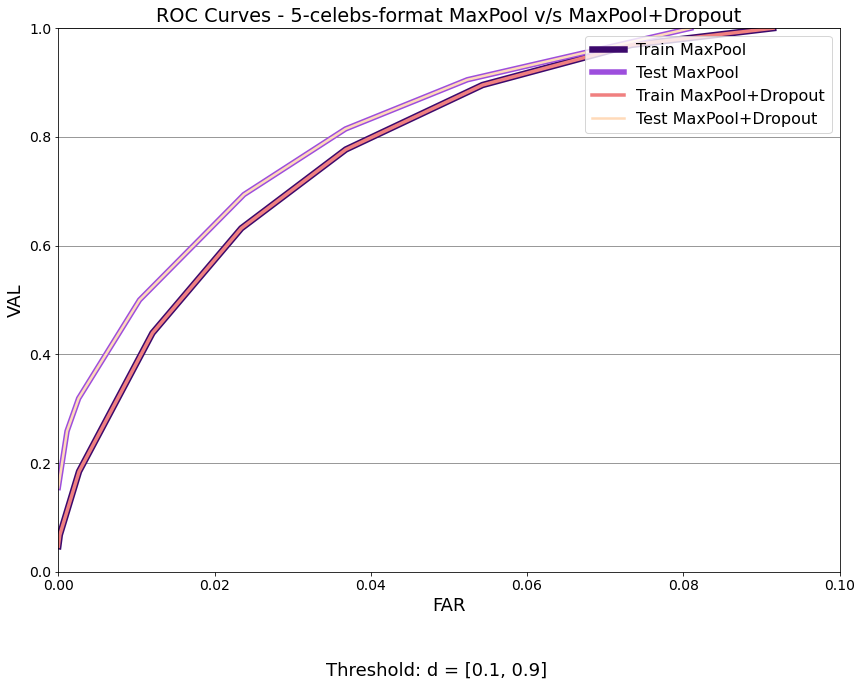

In [53]:
max_train_val = [0.047028086218158065, 0.06792945787067277, 0.1845199216198563, 0.4392553886348792, 0.6319399085564991, 0.7769431743958197, 0.8954931417374266, 0.969301110385369, 1.0]
max_train_far = [0.0, 0.0001928268414963363, 0.002651369070574624, 0.012051677593521017, 0.02342846124180486, 0.03680582337061319, 0.054304859236405705, 0.07337061318935596, 0.09149633629001157]
max_test_val = [0.15517241379310345, 0.25862068965517243, 0.31896551724137934, 0.5, 0.6939655172413793, 0.8146551724137931, 0.9051724137931034, 1.0, 1.0]
max_test_far = [0.0, 0.0011139992573338284, 0.0025993316004456, 0.0103973264017824, 0.02376531748978834, 0.03676197549201634, 0.052357965094689936, 0.08095061269959153, 0.08095061269959153]


drop_train_val = [0.047028086218158065, 0.06792945787067277, 0.1845199216198563, 0.4392553886348792, 0.6319399085564991, 0.7769431743958197, 0.8954931417374266, 0.969301110385369, 1.0]
drop_train_far = [0.0, 0.0001928268414963363, 0.002651369070574624, 0.012051677593521017, 0.02342846124180486, 0.03680582337061319, 0.054304859236405705, 0.07337061318935596, 0.09149633629001157]
drop_test_val = [0.15517241379310345, 0.25862068965517243, 0.31896551724137934, 0.5, 0.6939655172413793, 0.8146551724137931, 0.9051724137931034, 1.0, 1.0]
drop_test_far = [0.0, 0.0011139992573338284, 0.0025993316004456, 0.0103973264017824, 0.02376531748978834, 0.03676197549201634, 0.052357965094689936, 0.08095061269959153, 0.08095061269959153]

fig = plt.figure(figsize = (14,10))
ax = fig.add_subplot(1, 1, 1)
ax.yaxis.grid(linestyle = '-', color = 'gray')
plt.xticks(fontsize=14,fontweight='normal')
plt.yticks(fontsize=14,fontweight='normal')
plt.xlabel('FAR', fontsize=14)
plt.ylabel('VAL', fontsize=14)
plt.xlim(0,0.015)
plt.ylim(0,1)

ax.plot(max_train_far, max_train_val, '#3C096C', linewidth = 6.5, label = "Train MaxPool") # indigo
ax.plot(max_test_far, max_test_val, '#9D4EDD', linewidth = 5.5, label = "Test MaxPool") # dark orchid

ax.plot(drop_train_far, drop_train_val, '#F08080', linewidth = 3.5, label = "Train MaxPool+Dropout") # Light coral
ax.plot(drop_test_far, drop_test_val, '#FFDAB9', linewidth = 2.5, label = "Test MaxPool+Dropout") # Peach Puff

plt.rcParams.update({'font.size': 16})
plt.legend(loc = "upper right")
plt.title("ROC Curves - 5-celebs-format MaxPool v/s MaxPool+Dropout")
plt.ylabel("VAL", fontsize = 18)
plt.xlabel("FAR", fontsize = 18)
plt.suptitle('Threshold: d = [0.1, 0.9]',fontsize=18, y=0)
plt.xlim(0,0.1)
plt.ylim(0,1)
plt.savefig('../data/curves/retrained/5_celebs_format_maxpool_vs_maxpool_dropout_retrain.png')
plt.show()